# Estrategia de interacción con clientes para una cadena de gimnasios llamada Model Fitness

## Objetivo: Analizar los perfiles de los clientes y elaborar una estrategia de retención.

## Objetivos específicos: 
* Aprender a predecir la probabilidad de pérdida (para el próximo mes) para cada cliente.
* Elaborar retratos de usuarios típicos: selecciona los grupos más destacados y describe sus características principales.
* Analizar los factores que más impactan la pérdida.
* Sacar conclusiones básicas y elaborar recomendaciones para mejorar la atención al cliente:
    * identificar a los grupos objetivo;
    * sugerir medidas para reducir la rotación;
    * describir cualquier otro patrón que observes con respecto a la interacción con los clientes.


In [1]:
# Importa librerías
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as stats

# Visualización de librerías
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram

# Librerías Sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
)


## Paso 1. Descargar los datos

In [2]:
#Cargar y procesar la información del gimnasio
gym_data = pd.read_csv("gym_churn_us.csv")
gym_data.columns = gym_data.columns.str.lower()

# Mostrar la forma del dataset y el detalle de la información
print(f"Dataset contains {gym_data.shape[0]} rows and {gym_data.shape[1]} columns.")
gym_data.info()

Dataset contains 4000 rows and 14 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_fre

In [3]:
gym_data.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
gym_data.isnull().sum()

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

A primera vista, el conjunto de datos parece no tener valores faltantes y todos los datos ya se han convertido a formato numérico, lo que será útil para aplicar modelos predictivos más adelante en el proyecto.

## Paso 2. Llevar a cabo el análisis exploratorio de datos (EDA)

### Identificar si el dataset contiene alguna característica ausente y estudiar los valores promedio y la desviación estándar.

In [5]:
gym_data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Los usuarios pueden tener contratos de 1 mes, 6 meses o hasta 12 meses, siendo el período de contrato promedio de alrededor de 4 meses. Cabe destacar que el 75% de los clientes abandonan el servicio en un plazo de 6 meses. Además, los clientes no asisten a más de 6 clases por mes, con un promedio de 1,76 clases por mes, y el 75% de los usuarios asisten a alrededor de 2,5 clases. La desviación estándar de 1,05 sugiere que la mayoría de los usuarios no asisten a ninguna clase o asisten a un máximo de 2 clases. En términos de precios, la mayoría de los usuarios optan por contratos de 6 meses, con un cargo máximo de $552 por usuario.

### Observar los valores medios de las características en dos grupos: para las personas que se fueron (cancelación) y para las que se quedaron. 

In [6]:
churn_summary = gym_data.groupby('churn').mean()[
    ['contract_period', 'age', 'avg_additional_charges_total',
     'month_to_end_contract', 'lifetime',
     'avg_class_frequency_total', 'avg_class_frequency_current_month']
]
churn_summary

,contract_period,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,
0,5.747193,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,1.728558,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Los usuarios que abandonaron el gimnasio permanecieron en él menos de 2 meses, con una duración media del contrato de tan solo 0,99 meses, lo que indica que rara vez se quedan más allá del primer mes. A pesar de abandonar el gimnasio antes de tiempo, los usuarios que abandonaron gastaron en servicios adicionales, lo que muestra una diferencia de 43 dólares (27%) en comparación con los que no abandonaron el gimnasio. Por otro lado, los usuarios que no abandonaron el gimnasio tienen una duración media del contrato de 5,74 meses y una duración media del contrato de 4,71 meses. Esto refuerza aún más el hallazgo de que la mayoría de los usuarios no se quedan en el gimnasio más de 6 meses, lo que coincide con la información anterior de que el 75% de los usuarios tienen una duración y una duración del contrato de 6 meses o menos.

### Histogramas de barras y distribuciones de características para aquellas personas que se fueron (cancelación) y para las que se quedaron

In [7]:
columns_to_plot=['age','avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
                 'avg_class_frequency_total', 'avg_class_frequency_current_month']

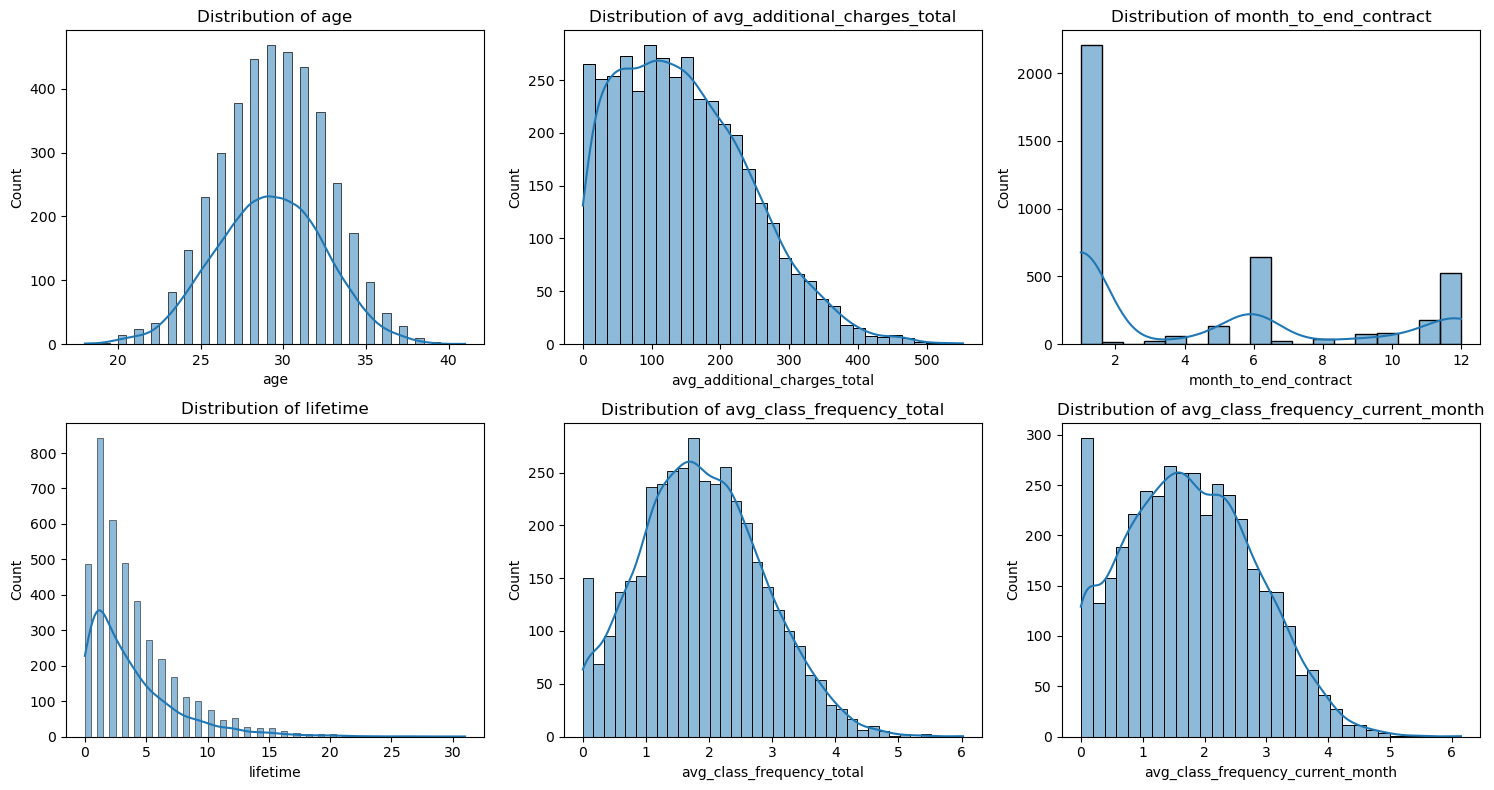

In [8]:
def plot_feature_distributions(dataframe):
    num_columns = 3
    num_features = len(dataframe.columns)
    num_rows = (num_features // num_columns) + (num_features % num_columns > 0)
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 4))
    axes = axes.flatten()

    for idx, col in enumerate(dataframe.columns):
        sns.histplot(dataframe[col], kde=True, ax=axes[idx])
        axes[idx].set_title(f'Distribution of {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Count')
    plt.tight_layout()
    plt.show()

plot_feature_distributions(gym_data[columns_to_plot])

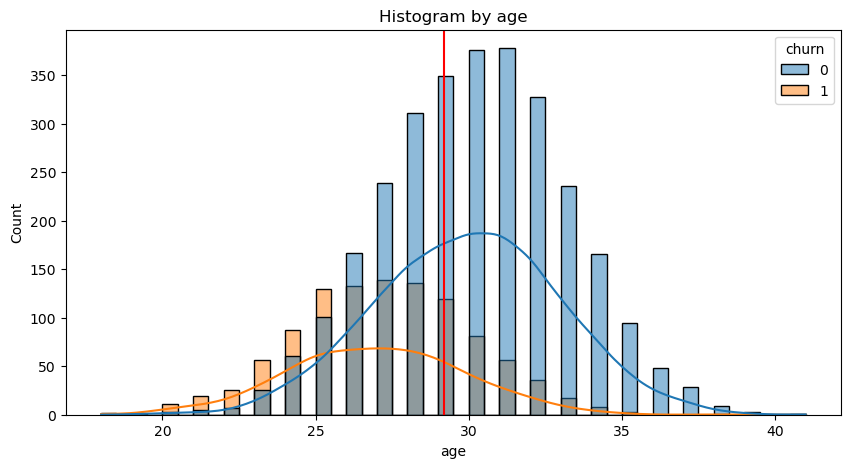

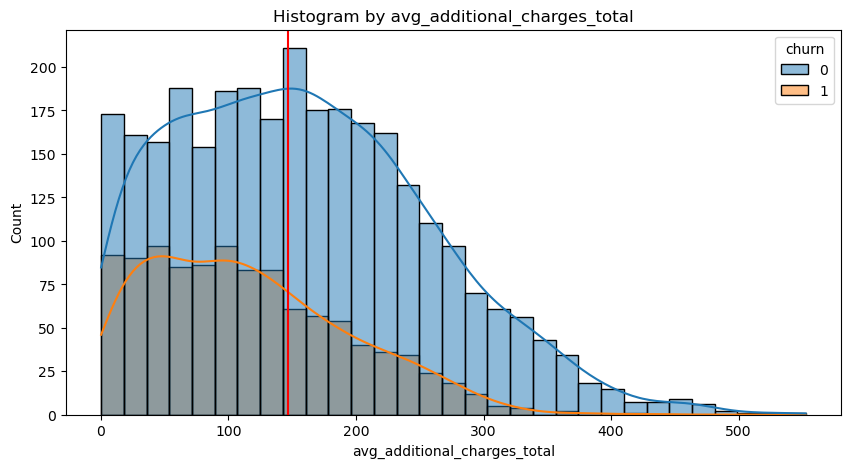

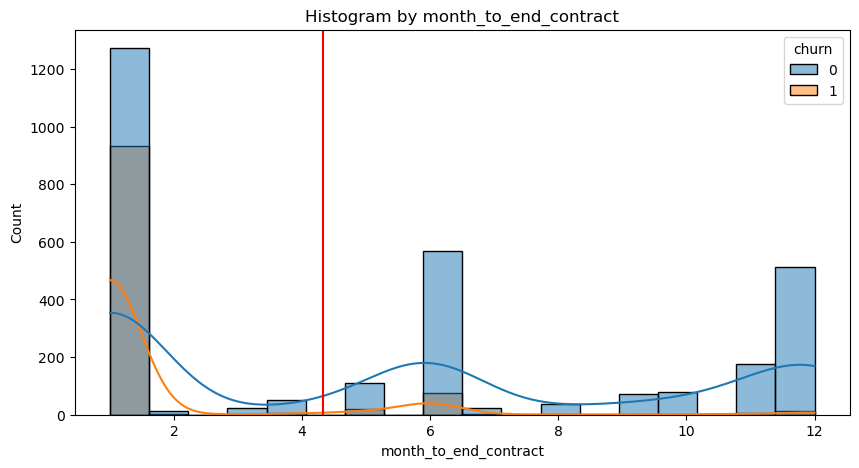

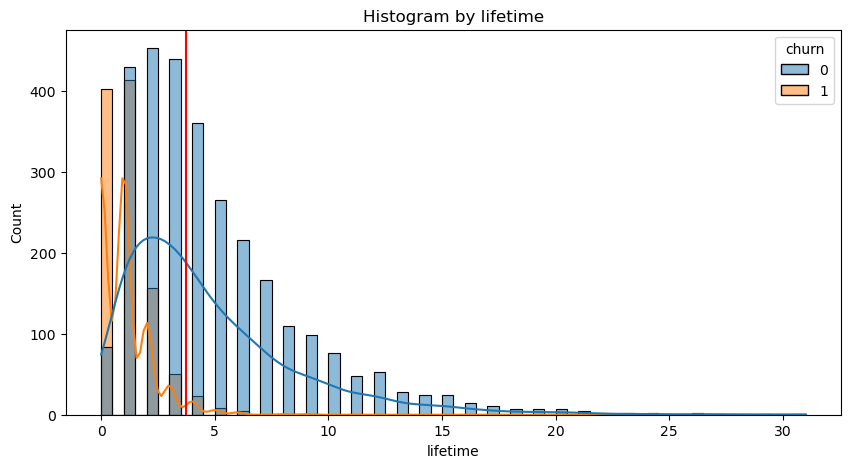

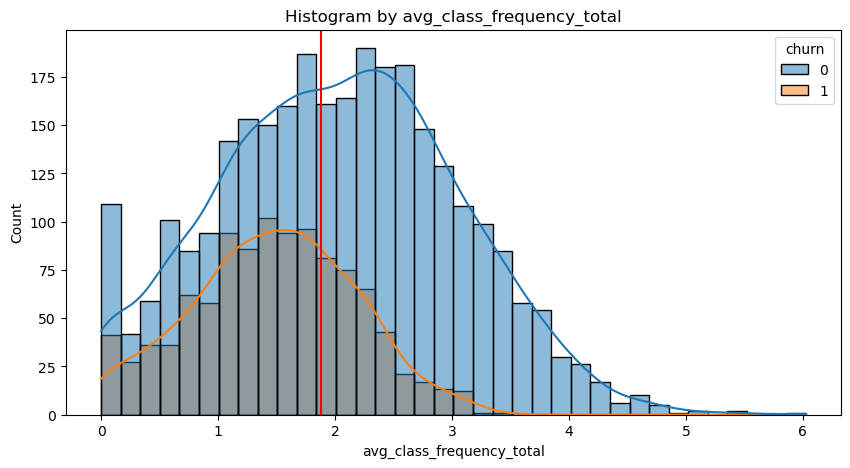

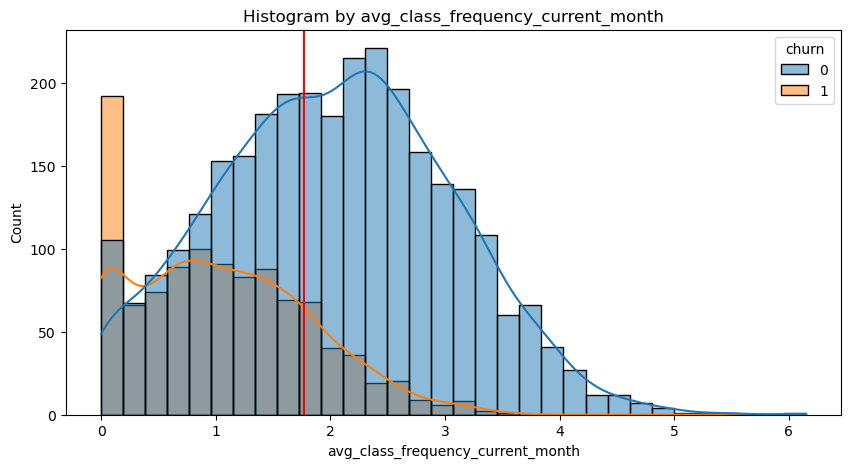

In [9]:
for col in columns_to_plot:
    mean=gym_data[col].mean()
    fig, ax = plt.subplots(figsize=(10,5))
    sns.histplot(data=gym_data, x=col, hue='churn', kde=True, ax=ax)
    plt.axvline(mean, color='r', linestyle='-', linewidth=1.5)
    title = f'Histogram by {col}'
    ax.set_title(title)
    plt.show()

### Análisis adicional

In [10]:
sns.set(style='whitegrid')

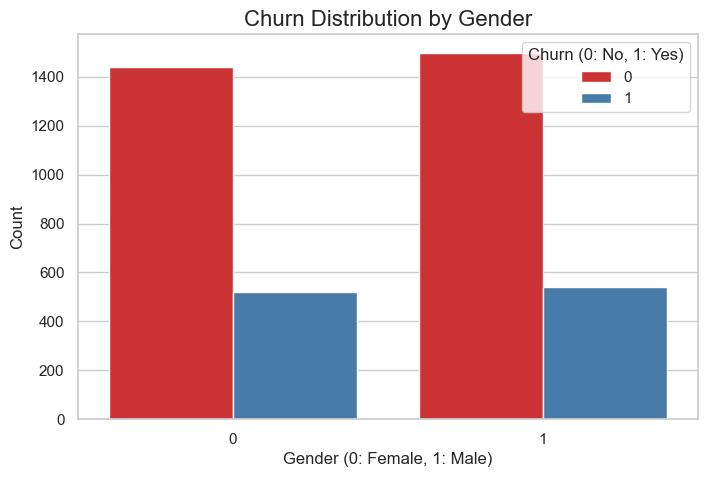

In [11]:
plt.figure(figsize=(8, 5))
sns.countplot(data=gym_data, x='gender', hue='churn', palette='Set1')
plt.title('Churn Distribution by Gender', fontsize=16)
plt.xlabel('Gender (0: Female, 1: Male)')
plt.ylabel('Count')
plt.legend(title='Churn (0: No, 1: Yes)')
plt.show()

/var/folders/zs/57ypgwyn03z1zjd7mcs7v8xr0000gn/T/ipykernel_2121/1819423727.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=gym_data, x='churn', y='contract_period', palette='Set1')


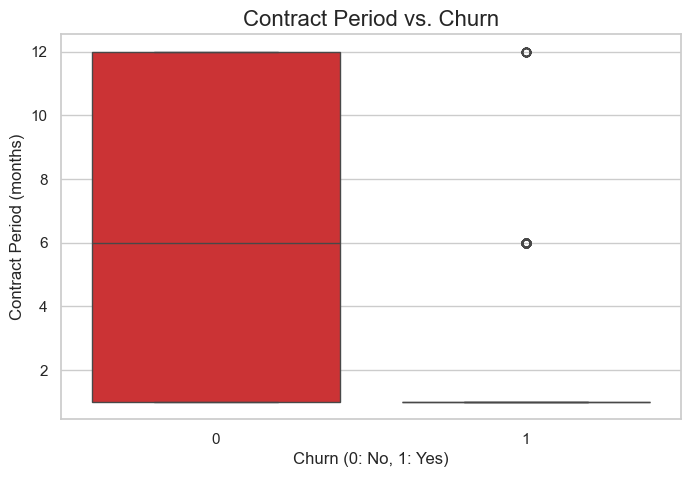

In [12]:
# Contract Period vs. Churn
plt.figure(figsize=(8, 5))
sns.boxplot(data=gym_data, x='churn', y='contract_period', palette='Set1')
plt.title('Contract Period vs. Churn', fontsize=16)
plt.xlabel('Churn (0: No, 1: Yes)')
plt.ylabel('Contract Period (months)')
plt.show()

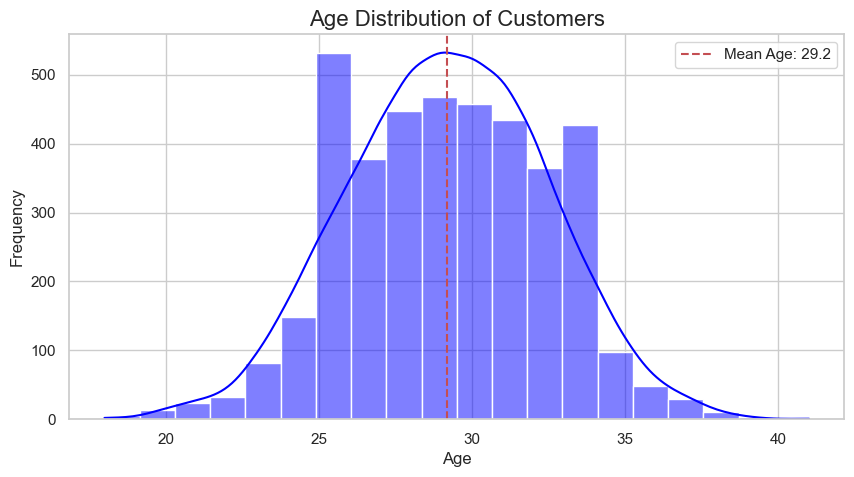

In [13]:
plt.figure(figsize=(10, 5))
sns.histplot(gym_data['age'], bins=20, kde=True, color='blue')
plt.axvline(gym_data['age'].mean(), color='r', linestyle='--', label=f'Mean Age: {gym_data["age"].mean():.1f}')
plt.title('Age Distribution of Customers', fontsize=16)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()

* El gráfico indica que la mayoría de los clientes se concentran entre los 20 y los 30 años, con una edad media de aproximadamente 29.2 años.

* La distribución está ligeramente sesgada hacia la derecha, lo que indica que hay algunos clientes mayores.

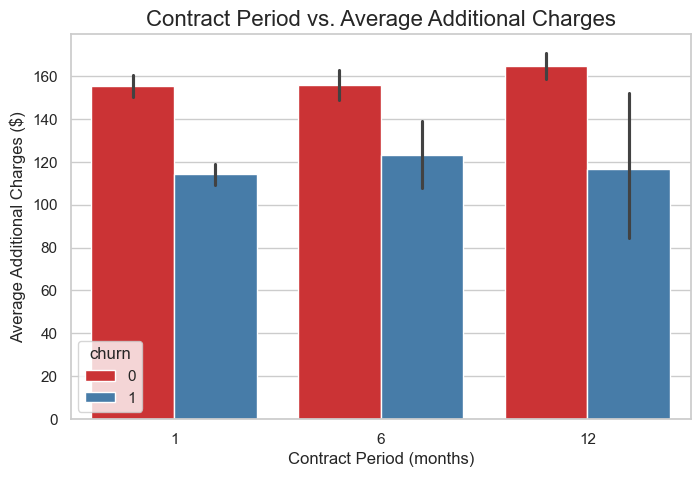

In [14]:
plt.figure(figsize=(8, 5))
sns.barplot(data=gym_data, x='contract_period', y='avg_additional_charges_total', hue='churn', palette='Set1')
plt.title('Contract Period vs. Average Additional Charges', fontsize=16)
plt.xlabel('Contract Period (months)')
plt.ylabel('Average Additional Charges ($)')
plt.show()

* Contratos más cortos (1 mes): Los clientes con un contrato de 1 mes que no abandonan el servicio tienden a gastar significativamente más en cargos adicionales que aquellos que abandonan el servicio. Esto sugiere que los usuarios que no abandonan el servicio con contratos a corto plazo pueden estar muy comprometidos y dispuestos a gastar más.

* Contratos más largos (6 y 12 meses): Los clientes que no abandonan el servicio con contratos de 6 y 12 meses también tienden a gastar más que los clientes que abandonan el servicio. Curiosamente, hay una caída notable en los cargos adicionales para los clientes que abandonan el servicio en todas las duraciones de los contratos, lo que indica que los clientes que no abandonan el servicio contribuyen menos económicamente más allá de su contrato base.

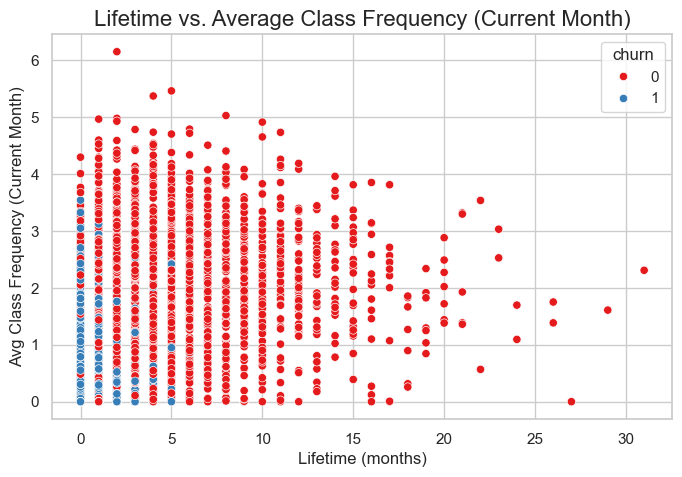

In [15]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=gym_data, x='lifetime', y='avg_class_frequency_current_month', hue='churn', palette='Set1')
plt.title('Lifetime vs. Average Class Frequency (Current Month)', fontsize=16)
plt.xlabel('Lifetime (months)')
plt.ylabel('Avg Class Frequency (Current Month)')
plt.show()

- **Cancelaciones:**
    
   Muchos de los clientes que se dieron de baja (puntos azules) parecen concentrarse en una vida más corta (0 a 6 meses) y una frecuencia de clases más baja, lo que sugiere que los clientes que asisten a menos clases y tienen membresías más cortas tienden a darse de baja con mayor frecuencia.

- **Clientes que no se dieron de baja:**

    Los puntos rojos (clientes que no se dieron de baja) se distribuyen en vidas más largas y frecuencias de clases más altas, lo que indica un uso más constante del gimnasio a lo largo del tiempo.

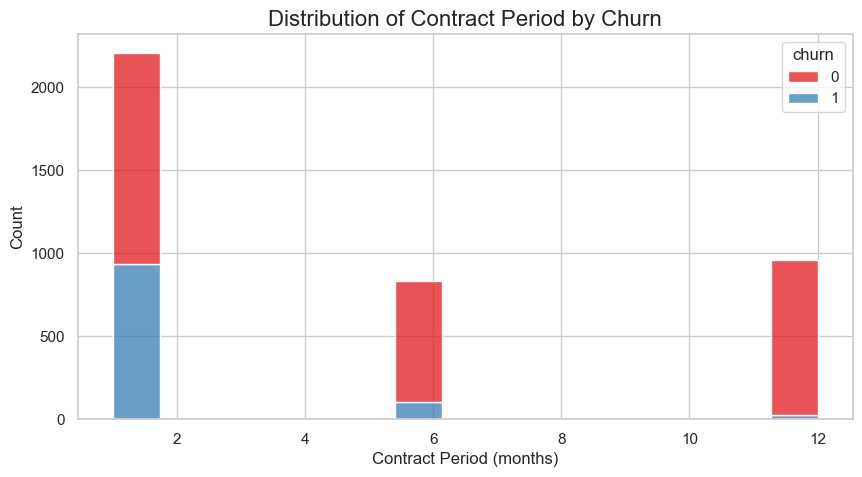

In [16]:
plt.figure(figsize=(10, 5))
sns.histplot(data=gym_data, x='contract_period', hue='churn', multiple='stack', palette='Set1', bins=15)
plt.title('Distribution of Contract Period by Churn', fontsize=16)
plt.xlabel('Contract Period (months)')
plt.ylabel('Count')
plt.show()

- **Contratos a corto plazo (1 mes):**

El gráfico revela que la mayoría de los clientes que abandonan el servicio (azul) se concentran en el período de contrato de 1 mes. Esto sugiere que los contratos más cortos están altamente correlacionados con la pérdida de clientes.

- **Contratos a mediano y largo plazo (6 y 12 meses):**

Los clientes con contratos de 6 y 12 meses tienen muchas menos probabilidades de abandonar el servicio. Casi todos los clientes con estos períodos de contrato más largos no abandonan el servicio (rojo).

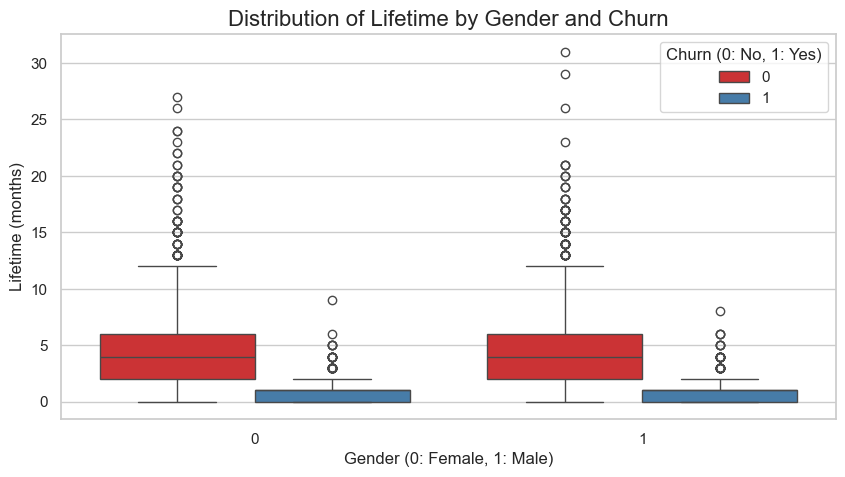

In [17]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=gym_data, x='gender', y='lifetime', hue='churn', palette='Set1')
plt.title('Distribution of Lifetime by Gender and Churn', fontsize=16)
plt.xlabel('Gender (0: Female, 1: Male)')
plt.ylabel('Lifetime (months)')
plt.legend(title='Churn (0: No, 1: Yes)')
plt.show()

- **Clientes que no cancelaron su cuenta:**

Tanto los clientes masculinos como femeninos que no abandonaron su cuenta (recuadros rojos) tienden a tener una vida útil más larga, con una mediana cercana a los 5 meses. La diferencia entre los clientes que no abandonaron su cuenta es más amplia, lo que indica una mayor variabilidad en la vida útil, ya que algunos clientes permanecen más de 20 meses.

- **Clientes que cancelaron su cuenta:**

Los clientes que abandonaron su cuenta (recuadros azules) tienen una vida útil mucho más corta, por lo general menos de 1 o 2 meses para ambos sexos. La diferencia es más estrecha y la presencia de valores atípicos indica que algunos clientes que abandonaron su cuenta tuvieron vidas útiles relativamente más largas.

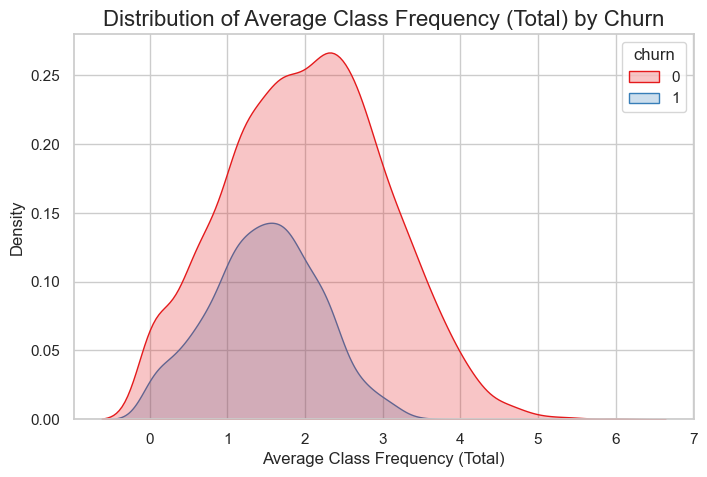

In [18]:
plt.figure(figsize=(8, 5))
sns.kdeplot(data=gym_data, x='avg_class_frequency_total', hue='churn', fill=True, palette='Set1')
plt.title('Distribution of Average Class Frequency (Total) by Churn', fontsize=16)
plt.xlabel('Average Class Frequency (Total)')
plt.ylabel('Density')
plt.show()

- **Clientes que no abandonan la clase (curva roja):**

Los clientes que no abandonan la clase tienden a tener una frecuencia media de clases más alta, con un pico de alrededor de 2 o 3 clases al mes. Esto indica que los clientes que asisten a clases con mayor frecuencia tienen menos probabilidades de abandonar la clase.

- **Clientes que abandonan la clase (curva azul):**

La curva azul muestra que los clientes que abandonan la clase suelen tener una asistencia media a clases más baja, con un pico de alrededor de 1 clase al mes o menos.

/var/folders/zs/57ypgwyn03z1zjd7mcs7v8xr0000gn/T/ipykernel_2121/4270430277.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=gym_data, x='churn', y='month_to_end_contract', palette='Set1')


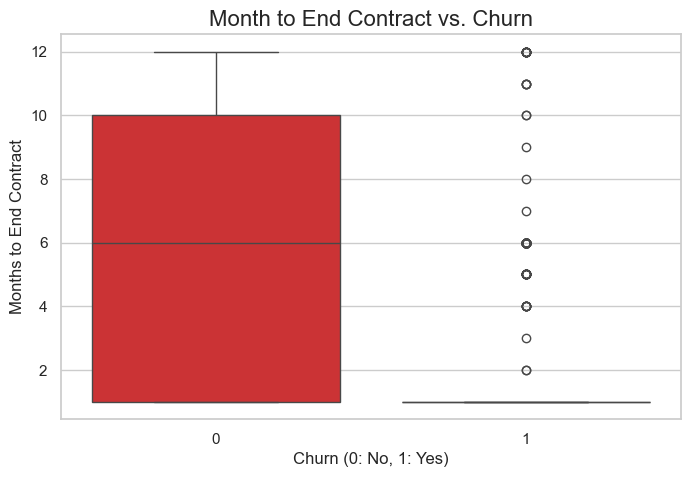

In [19]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=gym_data, x='churn', y='month_to_end_contract', palette='Set1')
plt.title('Month to End Contract vs. Churn', fontsize=16)
plt.xlabel('Churn (0: No, 1: Yes)')
plt.ylabel('Months to End Contract')
plt.show()

- **Clientes que no han cancelado su contrato (0):**

Los clientes que no han cancelado su contrato suelen tener más meses restantes, con una media de alrededor de 6 meses. La distribución también muestra una amplia gama de meses restantes (a algunos clientes les quedan hasta 12 meses).

- **Clientes que han cancelado su contrato (1):**

Los clientes que han cancelado su contrato suelen tener muy pocos meses restantes, con una media cercana a cero. Esto sugiere que los clientes que están cerca del final de sus contratos tienen muchas más probabilidades de abandonar su contrato.

### Resumen

1. **Distribución por edad (simétrica para ambos grupos):**
- La frecuencia de abandono de los usuarios es notablemente menor que la de los que no lo hacen.
- Los usuarios que abandonan el servicio tienen predominantemente entre 25 y 30 años, mientras que los que no lo hacen alcanzan su pico entre los 30 y los 33 años.

2. **Distribución de cargos adicionales (sesgada a la derecha):**
- Ambos grupos presentan distribuciones sesgadas a la derecha, lo que indica que los cargos adicionales tienden a permanecer bajos, generalmente por debajo de los $200, con una mediana de $136.
- Los usuarios que no abandonan el servicio tienden a gastar más, probablemente debido a sus períodos de contrato más largos y a la vida útil de los clientes.

3. **Distribución de meses hasta el final del contrato (no convencional):**
- La mayoría de los usuarios, en ambos grupos, tienen 1 mes restante en su contrato.
- Otros grupos notables incluyen usuarios a los que les quedan 6 y 12 meses.
- Pocos usuarios tienen contratos que finalizan en otros períodos de tiempo, con una duración media de contrato de 5 meses.

4. **Distribución de la vida útil del cliente (sesgada a la derecha):**
- Como se esperaba, los desertores tienen una vida útil de menos de 5 meses.
- Si bien algunos de los que no abandonan tienen una vida útil que se extiende más allá de los 20 meses, la frecuencia más alta de los que no abandonan sigue estando por debajo de los 5 meses.

5. **Total de clases a las que asiste (sesgada a la derecha):**
- Ningún usuario asiste a más de 6 clases durante su membresía.
- Las distribuciones muestran que los que no abandonan asisten a más de 2 clases, mientras que los que abandonan, con contratos más cortos, asisten a menos clases en general.

6. **Clases a las que asisten en el mes actual (sesgada a la derecha):**
- La mayoría de los usuarios no asistieron a ninguna clase en el mes actual.
- Sin embargo, los que no abandonan tienden a asistir al menos a 2 clases por mes según el histograma.

### Matriz de correlación 

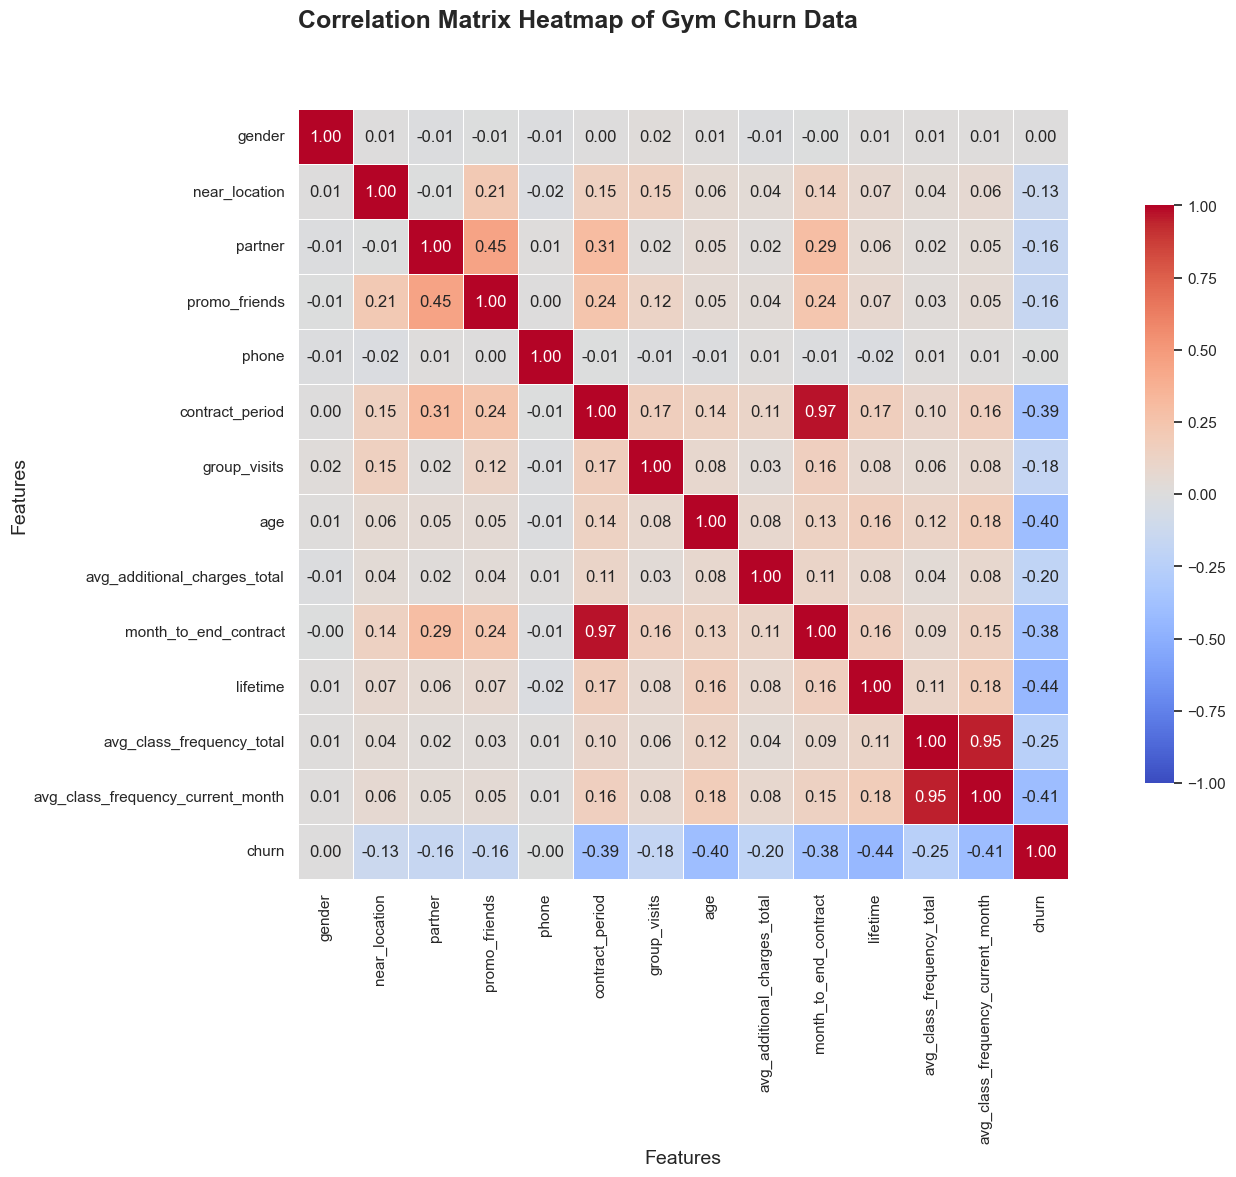

In [20]:
corr_matrix = gym_data.corr()

fig, ax = plt.subplots(figsize=(20, 10))

sns.heatmap(
    corr_matrix, annot=True, cmap='coolwarm', fmt='.2f',
    square=True, vmin=-1, vmax=1, linewidths=0.5, cbar_kws={"shrink": 0.75}
)

title = 'Correlation Matrix Heatmap of Gym Churn Data'
fig.suptitle(title, fontsize=18, fontweight='bold')

ax.set_xlabel('Features', fontsize=14)
ax.set_ylabel('Features', fontsize=14)
plt.show()

In [21]:
corr_matrix['churn'].sort_values()

lifetime                            -0.438220
avg_class_frequency_current_month   -0.412348
age                                 -0.404735
contract_period                     -0.389984
month_to_end_contract               -0.381393
avg_class_frequency_total           -0.249715
avg_additional_charges_total        -0.198697
group_visits                        -0.175325
promo_friends                       -0.162233
partner                             -0.157986
near_location                       -0.128098
phone                               -0.001177
gender                               0.000708
churn                                1.000000
Name: churn, dtype: float64

### Comentarios sobre la correlación

El conjunto de datos revela varios factores correlacionados con la pérdida de clientes. En particular, la vida útil del cliente tiene la correlación negativa más fuerte, seguida de la asistencia promedio a clases en el mes actual y la edad del cliente. Esto indica que los usuarios menos activos, especialmente aquellos menores de 30 años, tienen más probabilidades de abandonar el gimnasio.

**Factores clave que contribuyen a la pérdida de clientes:**
1. Edad
2. Vida útil del cliente
3. Duración del contrato
4. Frecuencia de asistencia a clases

**Correlaciones positivas:**
1. Promociones de amigos
2. Relaciones con empleados o recomendaciones de amigos de empleados

### Resumen del análisis exploratorio

A partir de nuestra exploración, podemos formular varias hipótesis para guiar un análisis posterior y desarrollar un modelo para comprender mejor el comportamiento del cliente, lo que en última instancia ayudará en las estrategias de retención de clientes.

**Hipótesis 1:**
- **H0:** Es probable que los usuarios menores de 35 años abandonen el gimnasio dentro de los 2 meses posteriores a su inscripción.
- **H1:** Los usuarios mayores de 35 años son generalmente más activos en comparación con los usuarios más jóvenes.

**Hipótesis 2:**
- **H0:** Los clientes que asisten a más clases tienen más probabilidades de quedarse más tiempo.
- **H1:** Los clientes que no asisten al menos a una clase por mes tienen más probabilidades de abandonar la cuenta.

**Hipótesis 3:**
- **H0:** Los clientes con contratos de más de 6 meses tienen menos probabilidades de abandonar la cuenta en comparación con los clientes mensuales.
- **H1:** Los clientes mensuales tienen una tasa de abandono más alta en comparación con aquellos con contratos de 12 meses.

## Paso 3. Construir un modelo para predecir la cancelación de usuarios

**Selección de características**

Para crear un modelo más eficaz, debemos seleccionar las características más relevantes que se alineen con nuestras hipótesis y patrones de comportamiento de los clientes. Con base en nuestro análisis anterior, nos centraremos en las siguientes características:

1. **Frecuencia de clases (total):** La cantidad total de clases a las que asistió el usuario durante el transcurso de su contrato, ya que puede indicar compromiso y probabilidad de permanencia.
2. **Tiempo de vida del cliente:** El tiempo que un cliente ha permanecido en el gimnasio, que puede influir en gran medida en la probabilidad de abandono.
3. **Cargos adicionales:** La cantidad gastada en servicios adicionales más allá del contrato estándar, que proporciona información sobre el compromiso del usuario.
4. **Período del contrato:** La duración del contrato actual del usuario, que se correlaciona directamente con el comportamiento de abandono.
5. **Edad del cliente:** La edad puede ser un factor clave, ya que los clientes más jóvenes parecen tener más probabilidades de abandonar el gimnasio según los hallazgos anteriores.

Estas características seleccionadas se utilizarán para entrenar el modelo para predecir el abandono de clientes.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

* Dividir los datos en conjuntos de entrenamiento y validación
* Entrenar el modelo en el set de entrenamiento con dos métodos:
     * regresión logística;
     * bosque aleatorio.
* Evaluar la exactitud, precisión y recall para ambos modelos utilizando los datos de validación. Identificar qué modelo da mejores resultados


In [23]:
X_features = gym_data[['lifetime','avg_class_frequency_current_month','age','contract_period',
                         'avg_class_frequency_total','avg_additional_charges_total','month_to_end_contract']]
y_variable = gym_data['churn']


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_variable, test_size=0.2, random_state=42, shuffle=True)

In [25]:
# Estandarizar las características
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

In [26]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=3000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=0),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=0),
    'Decision Tree': DecisionTreeClassifier(random_state=0)
}

In [27]:
model_results = {}
def evaluate_model(name, model, X_train_st, X_test_st, y_train, y_test):
    model.fit(X_train_st, y_train)
    predictions = model.predict(X_test_st)
    probabilities = model.predict_proba(X_test_st)[:,1]

    # Calcular las métricas
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, probabilities)

    # Guardar los resultados
    model_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }

    # Mostrar la evaluación de las métricas
    print(f"\n{name} Model Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, predictions))

    # Confusion Matrix
    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, probabilities)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="red")
    plt.title(f"{name} ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()


Logistic Regression Model Evaluation Metrics:
Accuracy: 0.92
Precision: 0.88
Recall: 0.78
F1 Score: 0.83
ROC AUC: 0.97

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       598
           1       0.88      0.78      0.83       202

    accuracy                           0.92       800
   macro avg       0.90      0.87      0.89       800
weighted avg       0.92      0.92      0.92       800



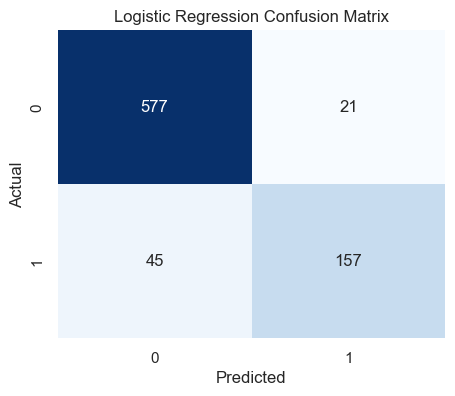

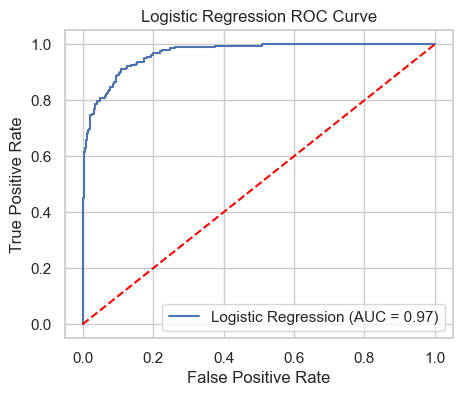


Random Forest Model Evaluation Metrics:
Accuracy: 0.91
Precision: 0.85
Recall: 0.79
F1 Score: 0.82
ROC AUC: 0.96

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       598
           1       0.85      0.79      0.82       202

    accuracy                           0.91       800
   macro avg       0.89      0.87      0.88       800
weighted avg       0.91      0.91      0.91       800



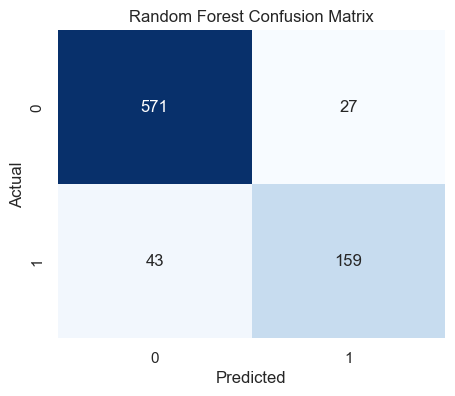

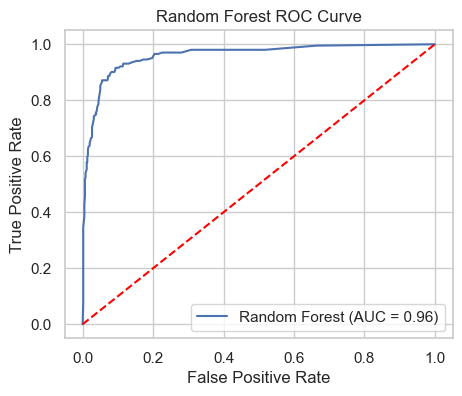


Gradient Boosting Model Evaluation Metrics:
Accuracy: 0.93
Precision: 0.88
Recall: 0.82
F1 Score: 0.85
ROC AUC: 0.97

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       598
           1       0.88      0.82      0.85       202

    accuracy                           0.93       800
   macro avg       0.91      0.89      0.90       800
weighted avg       0.92      0.93      0.92       800



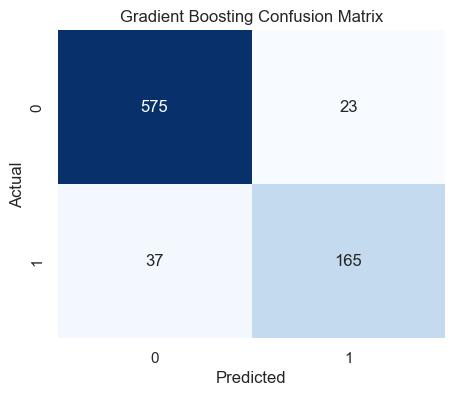

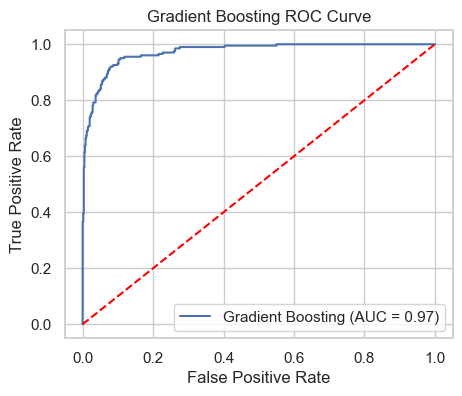


Decision Tree Model Evaluation Metrics:
Accuracy: 0.89
Precision: 0.78
Recall: 0.78
F1 Score: 0.78
ROC AUC: 0.85

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       598
           1       0.78      0.78      0.78       202

    accuracy                           0.89       800
   macro avg       0.85      0.85      0.85       800
weighted avg       0.89      0.89      0.89       800



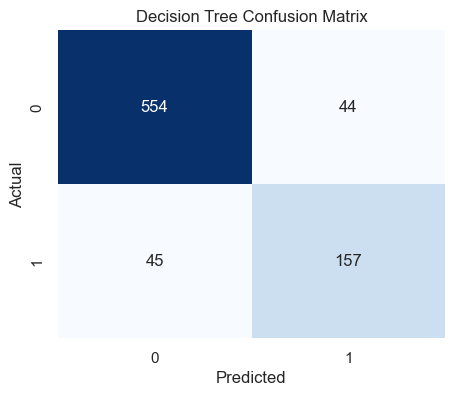

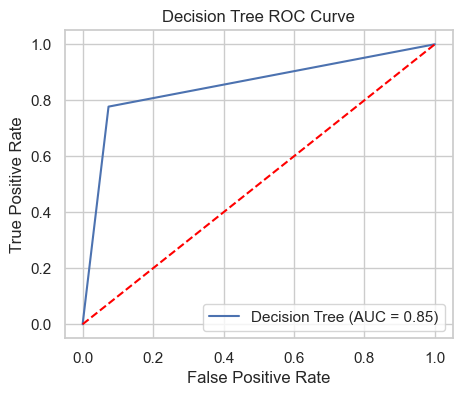

In [28]:
for name, model in models.items():
    evaluate_model(name, model, X_train_st, X_test_st, y_train, y_test)

In [29]:
performance_df = pd.DataFrame(model_results).T
print("\nComparación del rendimiento del modelo:\n")
print(performance_df)


Comparación del rendimiento del modelo:

                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Logistic Regression   0.91750   0.882022  0.777228  0.826316  0.967135
Random Forest         0.91250   0.854839  0.787129  0.819588  0.960110
Gradient Boosting     0.92500   0.877660  0.816832  0.846154  0.972487
Decision Tree         0.88875   0.781095  0.777228  0.779156  0.851825


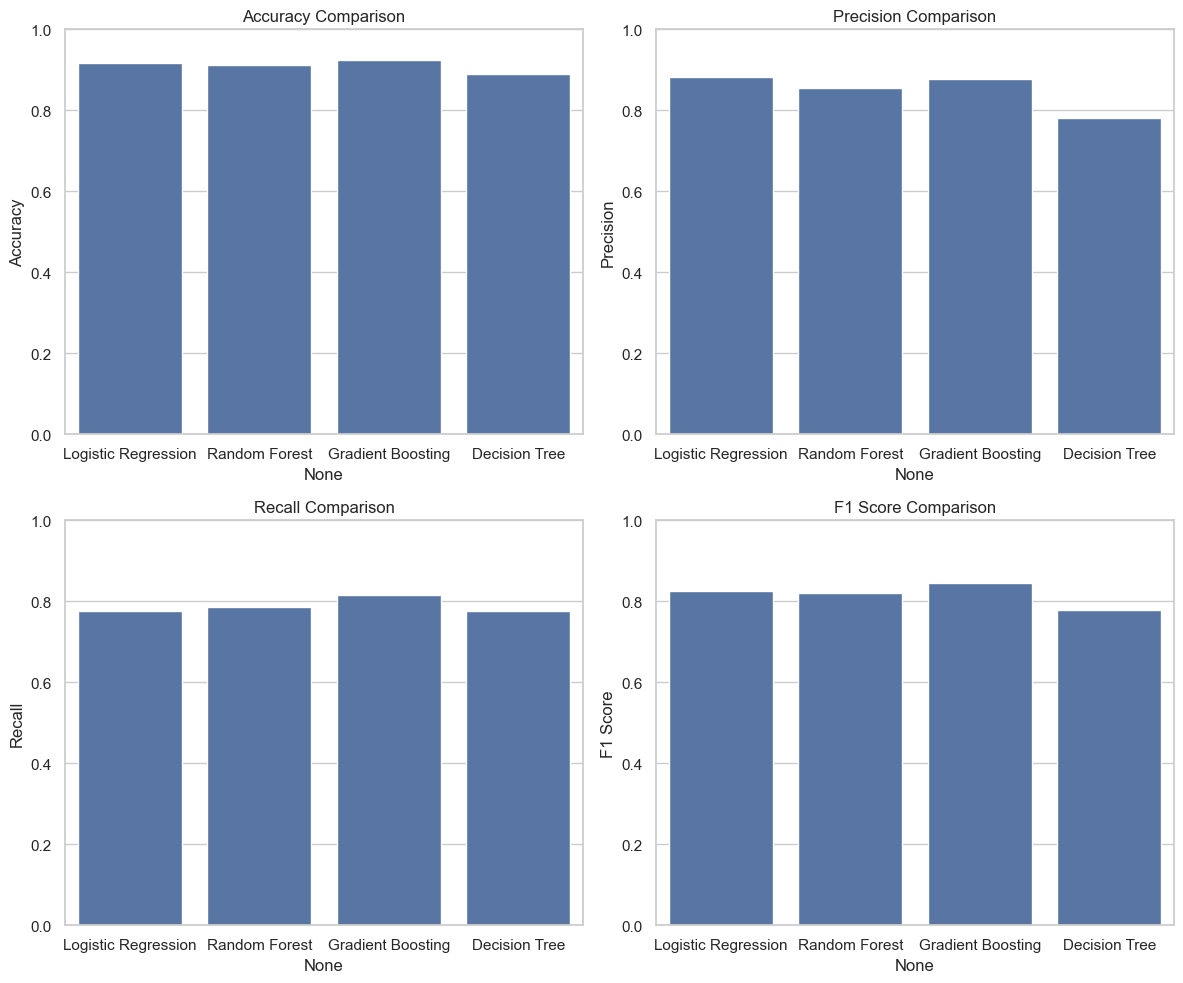

In [30]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
for i, metric in enumerate(metrics):
    sns.barplot(x=performance_df.index, y=performance_df[metric], ax=ax[i//2, i%2])
    ax[i//2, i%2].set_title(f"{metric} Comparison")
    ax[i//2, i%2].set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [31]:
def plot_feature_importance(model, model_name, feature_names):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(8, 5))
        sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette="viridis")
        plt.title(f"Feature Importance - {model_name}")
        plt.xlabel("Importance")
        plt.ylabel("Features")
        plt.show()


/var/folders/zs/57ypgwyn03z1zjd7mcs7v8xr0000gn/T/ipykernel_2121/1180133388.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette="viridis")


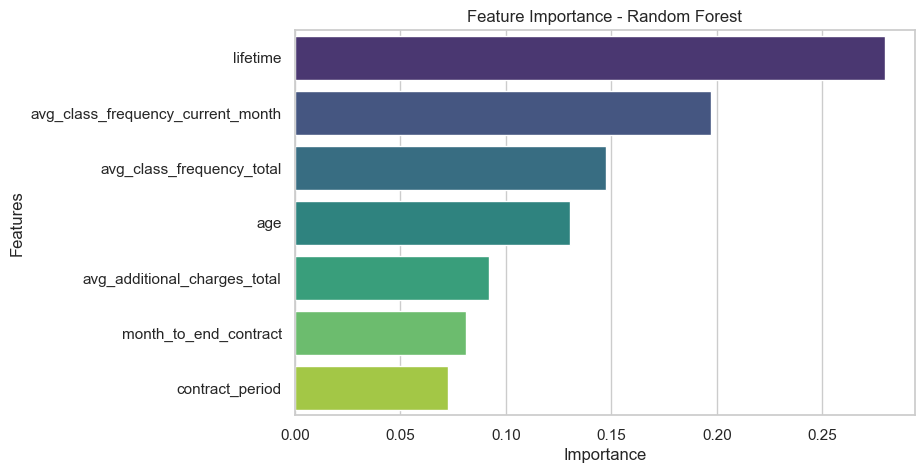

In [32]:

plot_feature_importance(models['Random Forest'], 'Random Forest', X_features.columns)

/var/folders/zs/57ypgwyn03z1zjd7mcs7v8xr0000gn/T/ipykernel_2121/1180133388.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette="viridis")


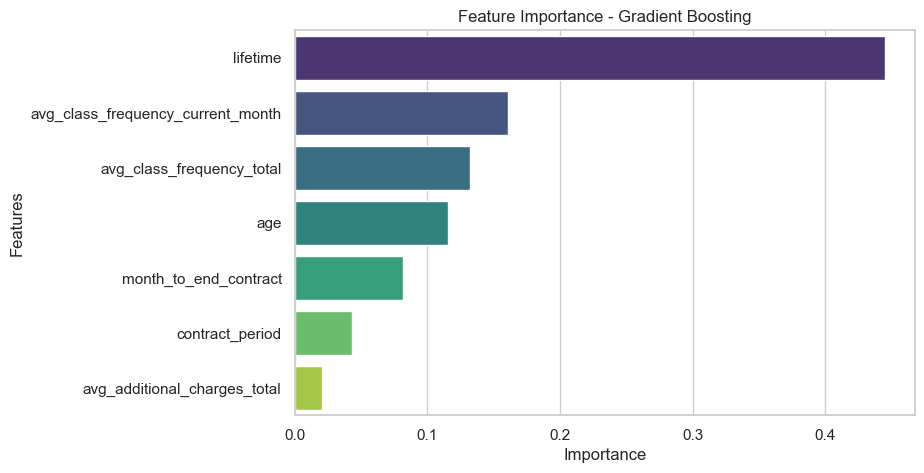

In [33]:
plot_feature_importance(models['Gradient Boosting'], 'Gradient Boosting', X_features.columns)

### Interpretación de la comparación del rendimiento de los modelos

La tabla resume el rendimiento de cuatro modelos (regresión logística, bosque aleatorio, potenciación de gradiente y árbol de decisiones) en función de varias métricas: precisión, exactitud, recuperación, puntuación F1 y área bajo la curva ROC. Analicemos cada métrica e interpretemos los resultados.

#### 1. **Precisión**
- **Regresión logística**: 91,75 %
- **Bosque aleatorio**: 91,25 %
- **Potenciación de gradiente**: 92,50 % (mejor precisión)
- **Árbol de decisiones**: 88,88 % (menor precisión)

La precisión representa la proporción de predicciones correctas del total de predicciones. Aquí, **Potenciación de gradiente** tiene la mayor precisión, ligeramente mejor que la regresión logística y el bosque aleatorio, lo que indica que realiza las predicciones más correctas en general. **Decision Tree** tiene la precisión más baja, lo que sugiere que puede ser menos confiable a la hora de predecir correctamente la variable objetivo (`churn`).

#### 2. **Precisión**
- **Regresión logística**: 88,20 %
- **Random Forest**: 85,48 %
- **Gradient Boosting**: 87,77 %
- **Decision Tree**: 78,11 % (precisión más baja)

La precisión mide la capacidad del modelo para evitar falsos positivos (es decir, predecir la pérdida de clientes cuando el cliente no lo hizo). En este caso, **Regresión logística** y **Gradient Boosting** tienen la precisión más alta, lo que significa que son mejores para identificar correctamente a los clientes que realmente abandonaron el servicio sin clasificar incorrectamente a los que no lo hicieron. **Decision Tree** tiene la precisión más baja, lo que indica una mayor probabilidad de falsos positivos.

#### 3. **Recall**
- **Regresión logística**: 77,72 %
- **Random Forest**: 78,71 %
- **Gradient Boosting**: 81,68 % (mejor recall)
- **Decision Tree**: 77,72 %

El recall mide la capacidad del modelo para identificar verdaderos positivos (es decir, predecir correctamente la pérdida de clientes). **Gradient Boosting** tiene la mayor recuperación, lo que significa que es mejor para identificar una mayor proporción de clientes que realmente abandonan el servicio. **Regresión logística** y **Árbol de decisiones** tienen una recuperación similar, que es menor que la de Gradient Boosting, lo que significa que pasan por alto un poco más de clientes que abandonan el servicio en comparación con Gradient Boosting.

#### 4. **Puntuación F1**
- **Regresión logística**: 82,63 %
- **Bosque aleatorio**: 81,96 %
- **Gradient Boosting**: 84,61 % (mejor puntuación F1)
- **Árbol de decisiones**: 77,91 % (puntuación F1 más baja)

La puntuación F1 es un equilibrio entre precisión y recuperación. **Gradient Boosting** tiene la puntuación F1 más alta, lo que indica que logra el mejor equilibrio entre precisión y recuperación, lo que lo convierte en un modelo más sólido para la predicción de la pérdida de clientes. **Árbol de decisiones** tiene la puntuación F1 más baja, lo que demuestra que es menos eficaz para equilibrar los falsos positivos y los falsos negativos.

#### 5. **ROC AUC (área bajo la curva de la característica operativa del receptor)**
- **Regresión logística**: 0,967 (excelente)
- **Random Forest**: 0,959
- **Gradient Boosting**: 0,972 (mejor AUC de ROC)
- **Decision Tree**: 0,851 (menor AUC de ROC)

El ROC AUC representa la capacidad del modelo para distinguir entre las dos clases (abandono y no abandono) en diferentes umbrales. Un AUC más alto indica una mejor capacidad para separar a los que abandonan de los que no abandonan. El **Gradient Boosting** tiene el AUC más alto, 0,972, lo que significa que es excelente para distinguir entre los que abandonan y los que no abandonan en todos los umbrales. El **Decision Tree** tiene el AUC más bajo, lo que sugiere que es menos confiable cuando se trata de separar las dos clases.

### Resumen general del rendimiento del modelo:
1. **Gradient Boosting**: en general, el Gradient Boosting tiene el mejor rendimiento en todas las métricas. Tiene la mayor precisión, recuperación, puntuación F1 y AUC ROC. Equilibra la precisión y la recuperación de manera eficaz y es muy capaz de distinguir entre los que abandonan y los que no. Este modelo probablemente sea la mejor opción para predecir la pérdida de clientes del gimnasio.

2. **Regresión logística**: la regresión logística tiene un buen rendimiento, en particular en términos de precisión y AUC ROC. Si bien su recuperación es ligeramente inferior a la del Gradient Boosting, sigue siendo un modelo confiable para la predicción de la pérdida.

3. **Random Forest**: el Random Forest también es un modelo sólido, con un rendimiento sólido en todas las métricas. Está ligeramente por detrás de la regresión logística y el Gradient Boosting, pero sigue siendo una opción viable, en particular si valora la interpretabilidad a través de la importancia de las características.

4. **Árbol de decisiones**: El árbol de decisiones tiene un rendimiento consistentemente inferior al de los otros modelos, con menor precisión, exactitud, puntuación F1 y AUC. Su estructura más simple puede generar sobreajuste y una capacidad de generalización reducida. Es probable que este modelo sea el menos adecuado para esta tarea en particular.

## Paso 4. Crear clústeres de usuarios/as

* Estandarizar los datos.
* Utilizar la función linkage() para crear una matriz de distancias basada en la matriz de características estandarizada y trazar un dendrograma. Utilizar el gráfico resultante para estimar el número de clústeres que puedes destacar.
* Entrenar el modelo de clustering con el algortimo K-means y predecir los clústeres de clientes.
* Analizar los valores medios de característica para los clústeres.
* Trazar distribuciones de características para los clústeres. 
* Calcular la tasa de cancelación para cada clúster 


In [34]:
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [35]:
sc = StandardScaler()
x_sc = sc.fit_transform(gym_data)

In [36]:
linked_data = linkage(x_sc, method='ward')

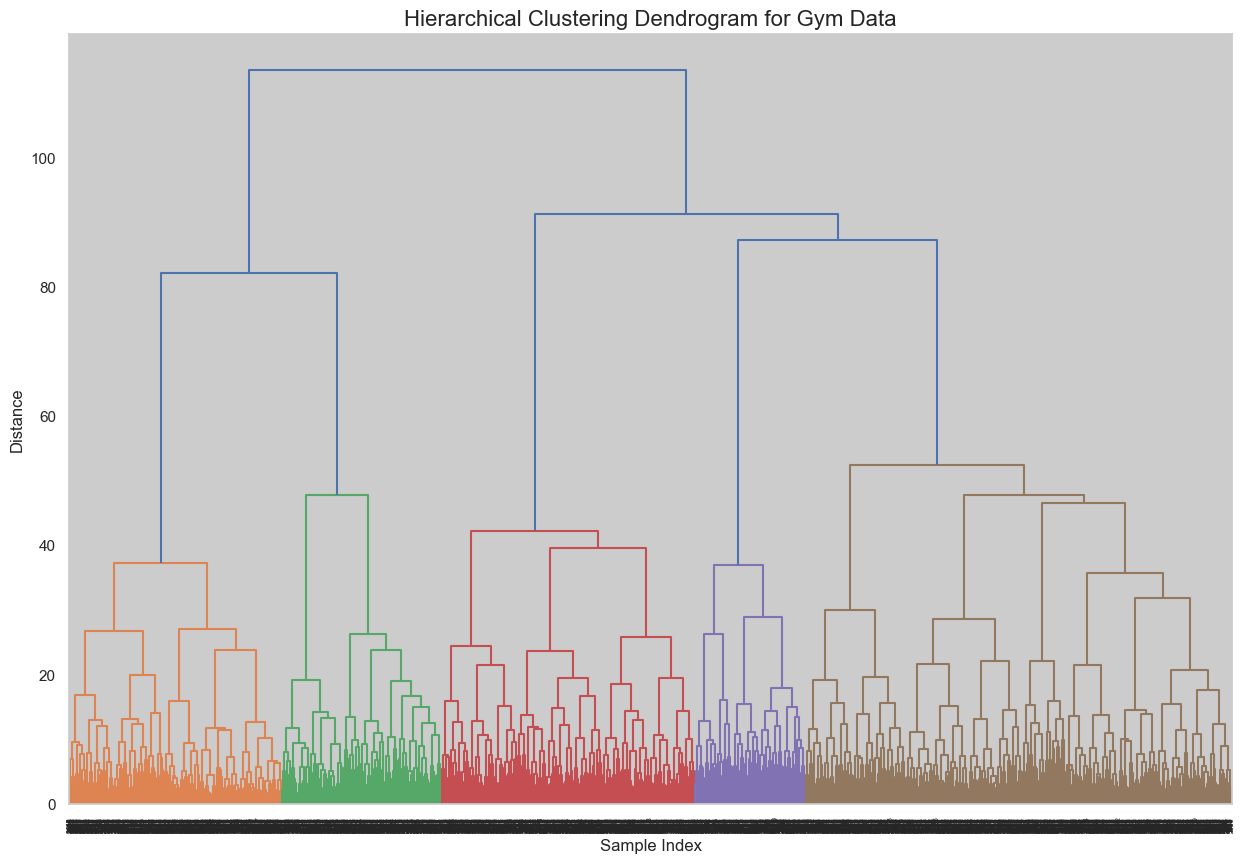

In [37]:
plt.figure(figsize=(15, 10))
dendrogram(linked_data, orientation='top')
plt.title('Hierarchical Clustering Dendrogram for Gym Data', fontsize=16)
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.xticks(rotation='vertical')
plt.show()

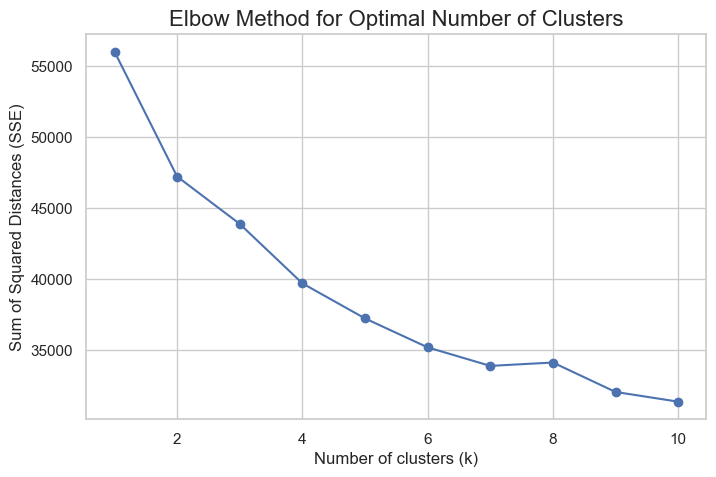

In [38]:
### Método para determinar la K óptima para K-medias ###
# Función para calcular la SSE (suma de distancias al cuadrado) para diferentes tamaños de clúster
sse = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(x_sc)
    sse.append(km.inertia_)


plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), sse, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal Number of Clusters', fontsize=16)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Distances (SSE)')
plt.show()

In [39]:
###Train K-means Clustering con 5 Clusters
km = KMeans(n_clusters=5, random_state=42)
labels = km.fit_predict(x_sc)

In [40]:
gym_data['cluster_km'] = labels

In [41]:
#compute the silhouette score to evaluate clustering quality
silhouette_avg = silhouette_score(x_sc, labels)
print(f'Silhouette Score for K-means with 5 clusters: {silhouette_avg:.2f}')

Silhouette Score for K-means with 5 clusters: 0.15


In [42]:
gym_data.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,cluster_km
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0,3
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0,2
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0,4
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0,2
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0,4


**Análisis de Cluster:Valores de promedio por Cluster**

In [43]:
cluster_summary = gym_data.groupby('cluster_km').agg({
    'gender':'mean',
    'near_location':'mean',
    'partner':'mean',
    'promo_friends':'mean',
    'phone':'mean',
    'contract_period':'mean',
    'group_visits':'mean',
    'age':'mean',
    'avg_additional_charges_total':'mean',
    'month_to_end_contract':'mean',
    'lifetime':'mean',
    'avg_class_frequency_total':'mean',
    'avg_class_frequency_current_month':'mean',
    'churn':'mean'
})
cluster_summary

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.508475,1.000000,0.332464,0.226858,1.0,1.646675,0.285528,26.915254,114.995594,1.594524,1.061278,1.402755,1.007382,0.932203
1,0.499033,0.000000,0.462282,0.077369,1.0,2.292070,0.216634,28.564797,136.165668,2.160542,2.843327,1.732190,1.554870,0.433269
2,0.506399,0.956124,0.786106,0.574954,1.0,10.628885,0.546618,29.887569,159.938050,9.675503,4.621572,2.007334,2.001950,0.013711
3,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967,0.266839
4,0.515372,0.999191,0.332524,0.220874,1.0,2.269417,0.449029,30.193366,160.630304,2.137540,4.885113,2.130157,2.132761,0.003236


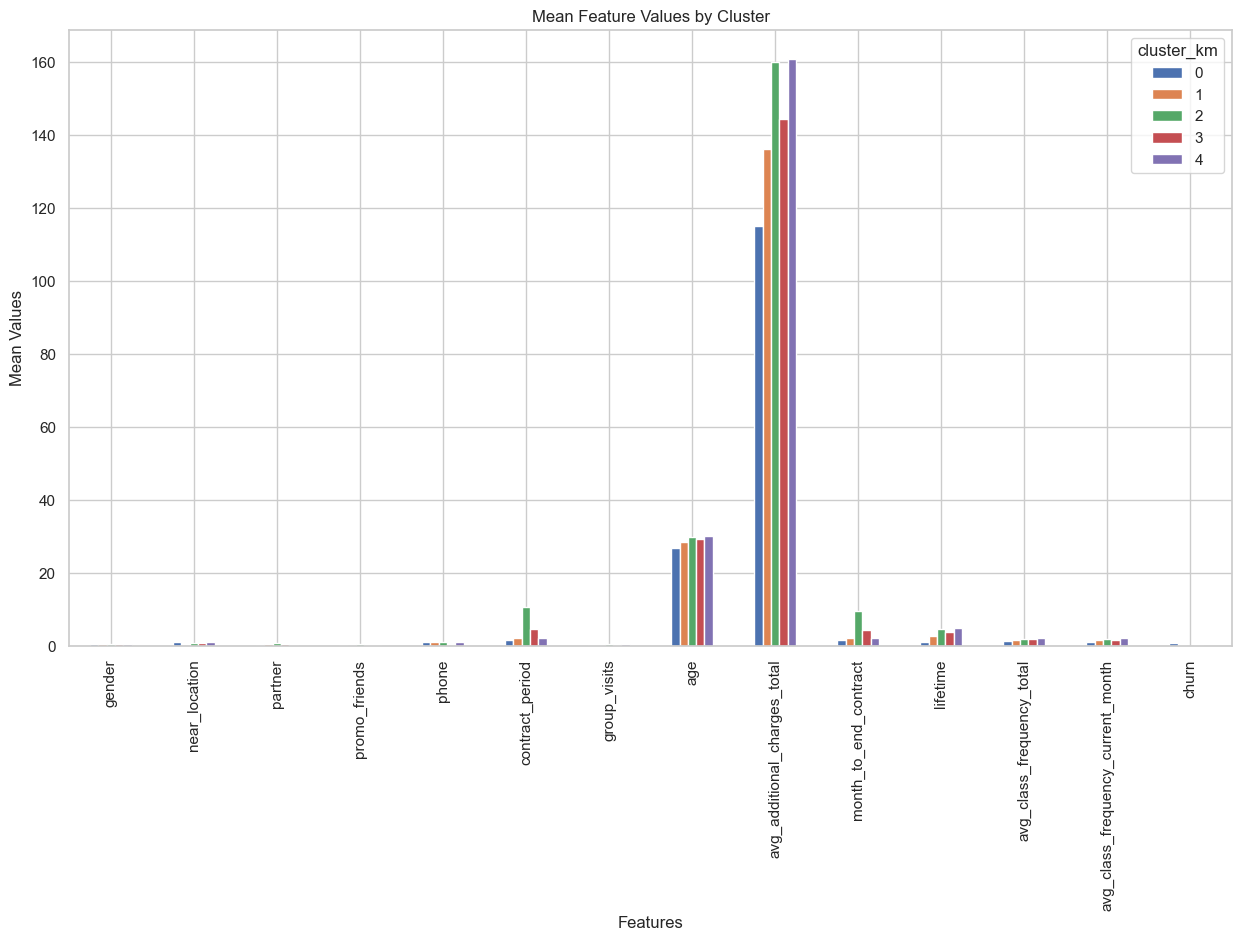

In [44]:
cluster_summary.T.plot(kind='bar', figsize=(15, 8), title='Mean Feature Values by Cluster')
plt.ylabel('Mean Values')
plt.xlabel('Features')
plt.show()

**Visualización de Clústeres en proyecciones 2D**

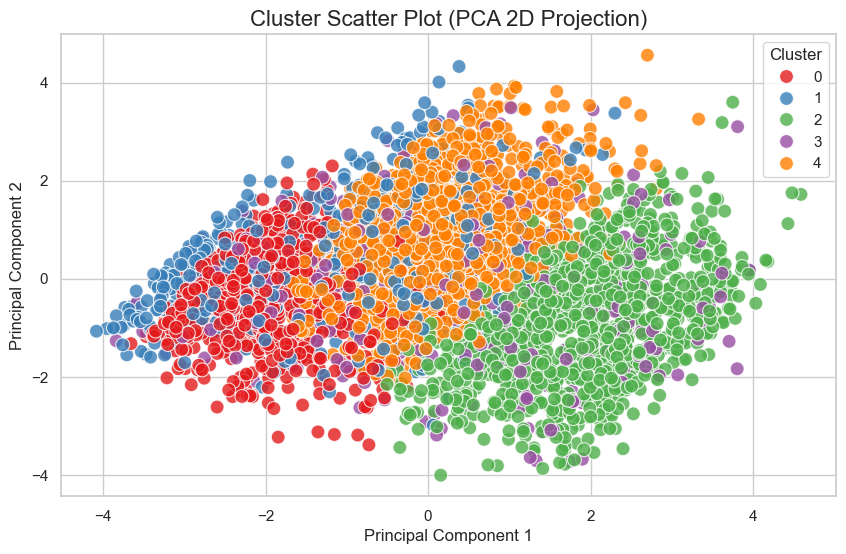

In [45]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_sc)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='Set1', s=100, alpha=0.8)
plt.title('Cluster Scatter Plot (PCA 2D Projection)', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title="Cluster")
plt.show()

**Distribución de características por Cluster**

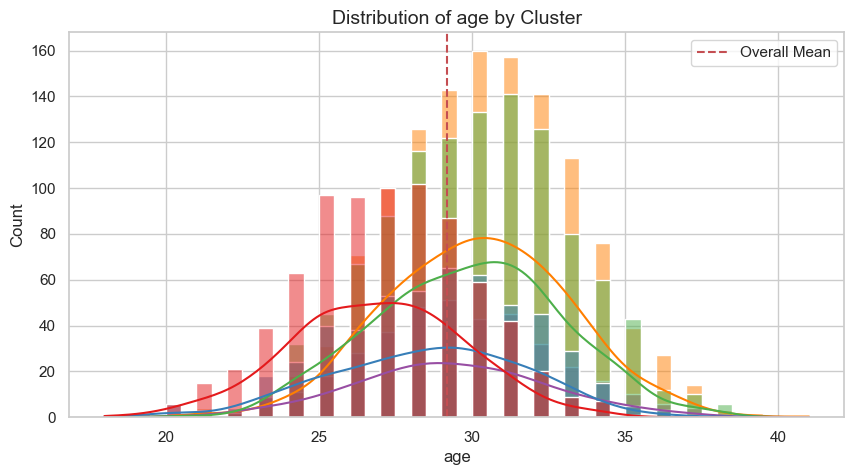

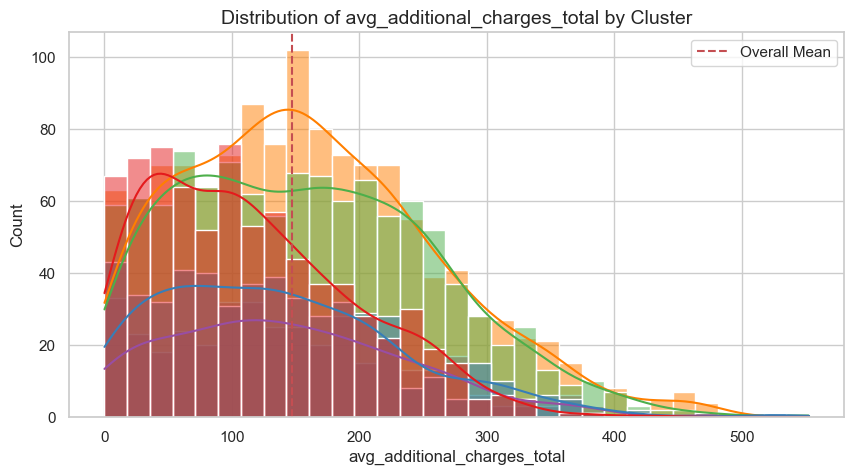

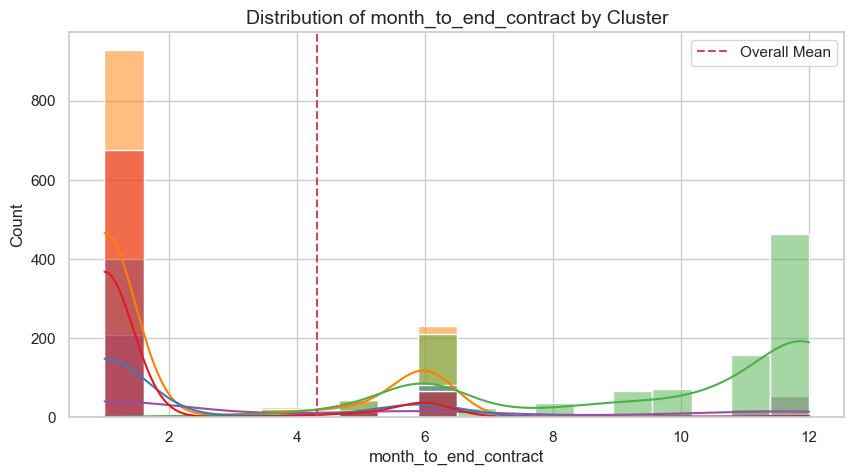

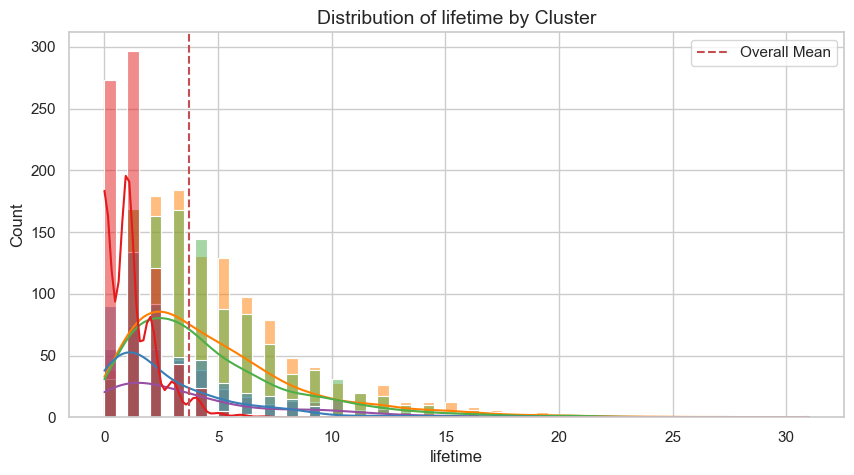

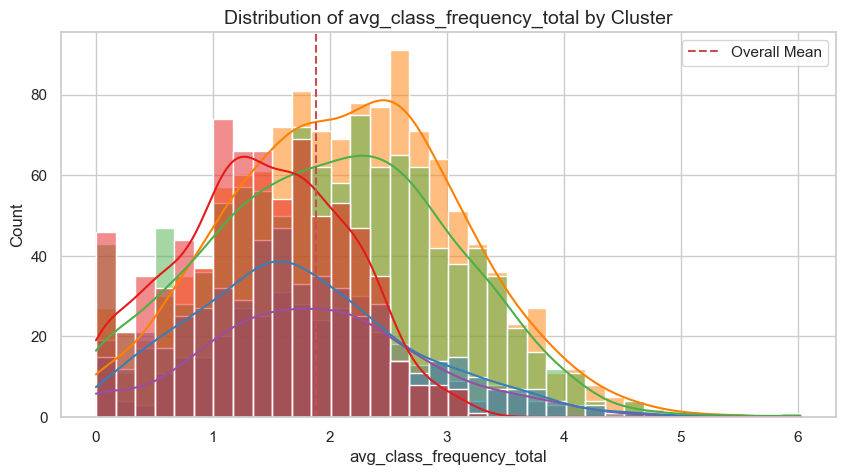

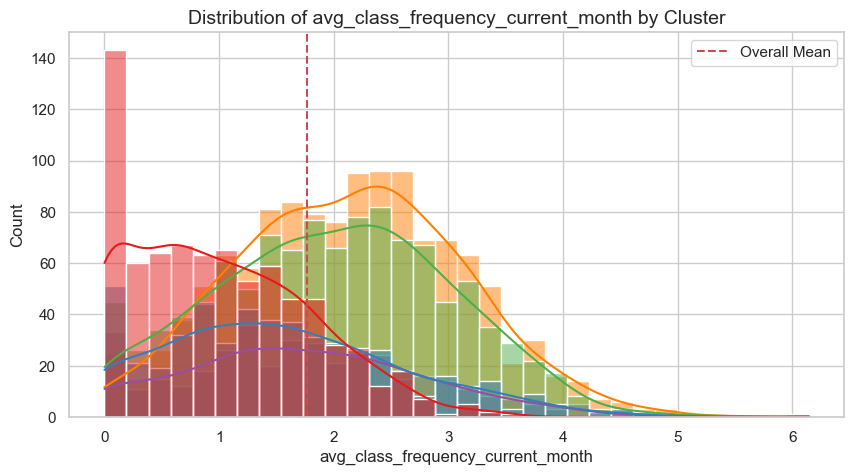

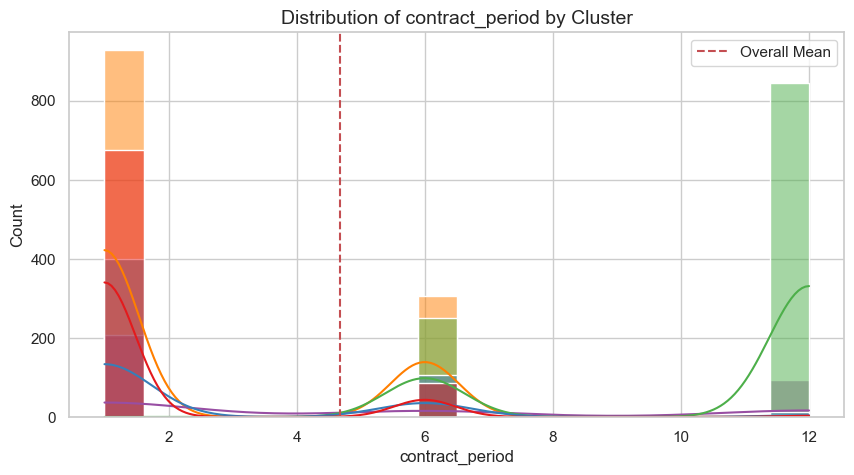

In [46]:
columns_to_plot_clusters = ['age', 'avg_additional_charges_total', 'month_to_end_contract',
                            'lifetime', 'avg_class_frequency_total',
                            'avg_class_frequency_current_month', 'contract_period']

for col in columns_to_plot_clusters:
    mean = gym_data[col].mean()
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.histplot(data=gym_data, x=col, hue='cluster_km', kde=True, ax=ax, palette='Set1')
    plt.axvline(mean, color='r', linestyle='--', linewidth=1.5, label='Overall Mean')
    ax.set_title(f'Distribution of {col} by Cluster', fontsize=14)
    ax.legend()
    plt.show()

**Comparar características de distribución por cluster**

/var/folders/zs/57ypgwyn03z1zjd7mcs7v8xr0000gn/T/ipykernel_2121/3127060391.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_km', y='lifetime', data=gym_data, palette='Set1')


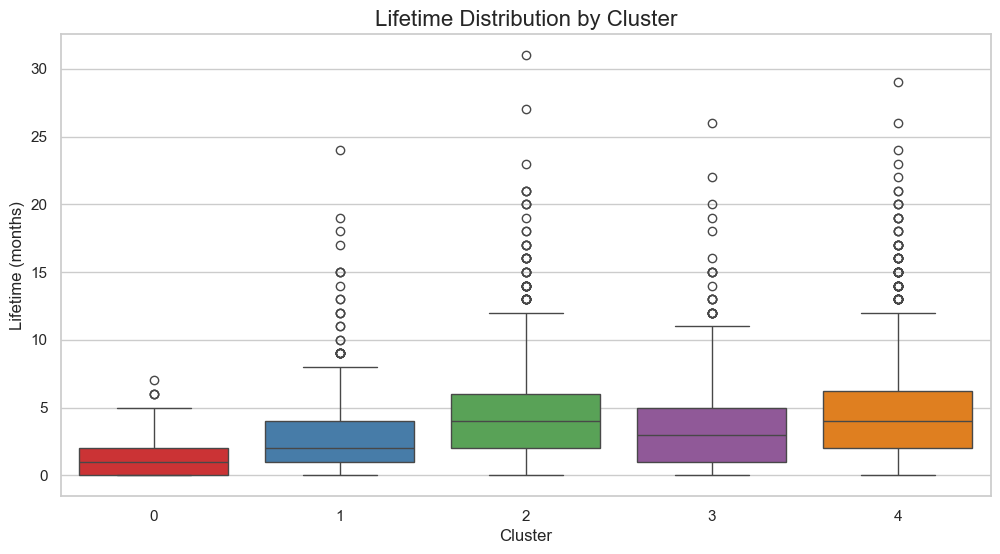

/var/folders/zs/57ypgwyn03z1zjd7mcs7v8xr0000gn/T/ipykernel_2121/3127060391.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_km', y='contract_period', data=gym_data, palette='Set1')


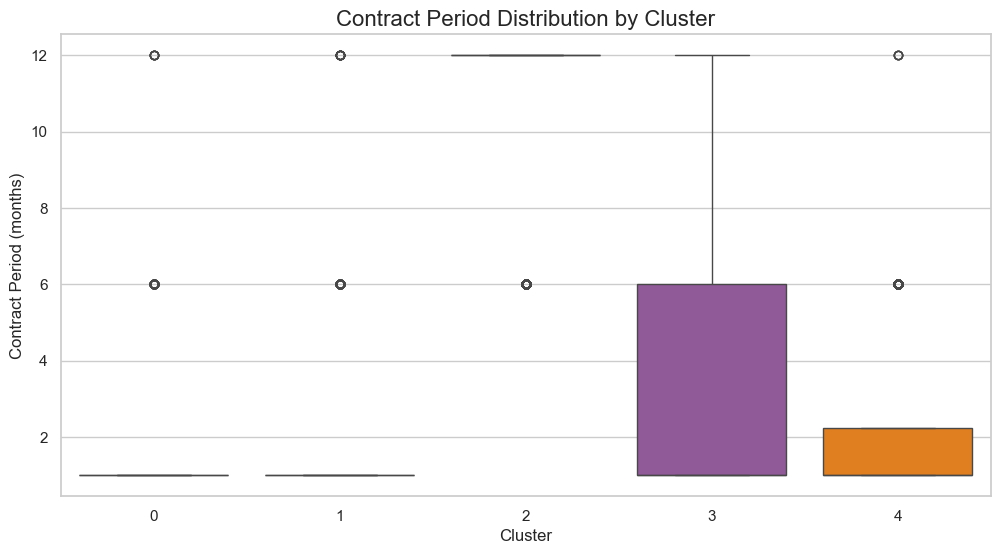

In [47]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster_km', y='lifetime', data=gym_data, palette='Set1')
plt.title('Lifetime Distribution by Cluster', fontsize=16)
plt.xlabel('Cluster')
plt.ylabel('Lifetime (months)')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster_km', y='contract_period', data=gym_data, palette='Set1')
plt.title('Contract Period Distribution by Cluster', fontsize=16)
plt.xlabel('Cluster')
plt.ylabel('Contract Period (months)')
plt.show()

**Tasas de cancelación por Cluster**

In [48]:
gym_data['churned'] = gym_data['churn'].where(gym_data['churn'] == 1, other=np.nan)
gym_data['non_churned'] = gym_data['churn'].where(gym_data['churn'] == 0, other=np.nan)

In [49]:
churn_rate = gym_data.groupby('cluster_km').agg({
    'churned':'count',
    'non_churned':'count'
})
churn_rate['customers_at_start'] = churn_rate['churned'] + churn_rate['non_churned']
churn_rate['churn_rate'] = churn_rate['churned'] / churn_rate['customers_at_start']

print(churn_rate)

            churned  non_churned  customers_at_start  churn_rate
cluster_km                                                      
0               715           52                 767    0.932203
1               224          293                 517    0.433269
2                15         1079                1094    0.013711
3               103          283                 386    0.266839
4                 4         1232                1236    0.003236


/var/folders/zs/57ypgwyn03z1zjd7mcs7v8xr0000gn/T/ipykernel_2121/4070024669.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate.index, y=churn_rate['churn_rate'], palette='Set1')


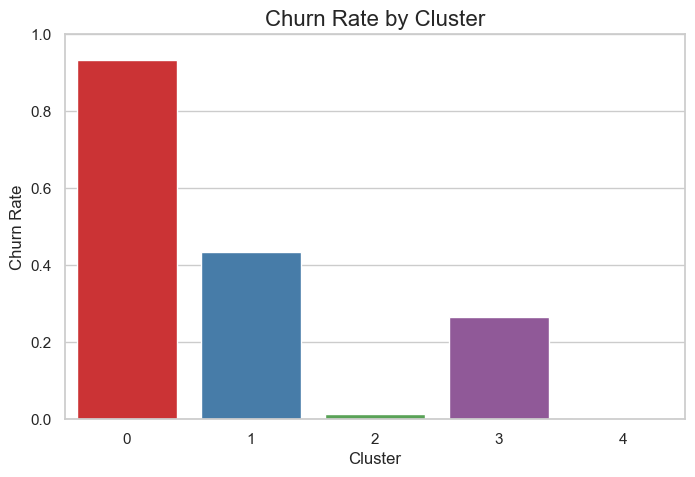

In [50]:
plt.figure(figsize=(8, 5))
sns.barplot(x=churn_rate.index, y=churn_rate['churn_rate'], palette='Set1')
plt.title('Churn Rate by Cluster', fontsize=16)
plt.ylabel('Churn Rate')
plt.xlabel('Cluster')
plt.ylim(0, 1)
plt.show()

### Interpretación detallada de las tasas de cancelación por clúster

La siguiente tabla resume el comportamiento de cancelación de cada clúster, incluida la cantidad de clientes que abandonaron y no abandonaron, la cantidad total de clientes en cada clúster y la tasa de abandono de cada clúster.

| Cluster | Churned | Non-Churned | Customers at Start | Churn Rate |
|---------|---------|-------------|--------------------|------------|
| **0**   | 715     | 52          | 767                | 93.22%     |
| **1**   | 224     | 293         | 517                | 43.33%     |
| **2**   | 15      | 1079        | 1094               | 1.37%      |
| **3**   | 103     | 283         | 386                | 26.68%     |
| **4**   | 4       | 1232        | 1236               | 0.32%      |

#### Grupo 0: **Grupo de alto riesgo de cancelación (tasa de cancelación del 93,22 %)**
- **Clientes totales**: 767
- **Cancelados**: 715
- **No cancelados**: 52
- **Tasa de cancelación**: 93,22 %

Este grupo presenta **tasas de cancelación extremadamente altas**, con más del **93 % de los clientes que abandonan el gimnasio**. Es probable que este grupo contenga a los clientes más desconectados, con un período de retención muy corto. Es posible que el gimnasio deba investigar las razones subyacentes de una tasa de acancelación tan alta en este grupo, como la insatisfacción con los servicios, los precios o la experiencia general. Dirigirse a este grupo con estrategias de retención, como ofertas o incentivos personalizados, podría ser crucial para reducir la tasa de cancelación.

#### Grupo 1: **Grupo de riesgo de cancelación moderado (tasa de cancelacióndel 43,33 %)**
- **Clientes totales**: 517
- **Cancelados**: 224
- **No cancelados**: 293
- **Tasa de cancelación**: 43,33 %

Este grupo tiene una **tasa de cancelación moderada** de alrededor del **43 %**, lo que indica que casi la mitad de los clientes de este grupo han abandonado el gimnasio. La mitad restante parece estar algo comprometida, pero hay margen de mejora. Es posible que el gimnasio quiera centrarse en este grupo con iniciativas de participación para garantizar la retención. Por ejemplo, ofrecer nuevas clases, desafíos de fitness o recompensas de fidelidad podría ayudar a retener a los clientes de este grupo.

#### Grupo 2: **Grupo de clientes leales (tasa de cancelación del 1,37 %)**
- **Total de clientes**: 1094
- **Cancelados**: 15
- **No cancelados**: 1079
- **tasa de cancelación**: 1,37 %

El grupo 2 es, por lejos, el **grupo de clientes más leales**, con una tasa de cancelación extremadamente baja del **1,37 %**. De los 1094 clientes de este grupo, solo 15 se han ido. Este grupo probablemente representa a los **clientes leales y principales** del gimnasio, que están muy satisfechos con los servicios y las ofertas del gimnasio. El gimnasio debería apuntar a **retener y recompensar a estos clientes** para mantener esta fuerte lealtad. Este grupo podría aprovecharse para promover referencias o proporcionar testimonios para atraer nuevos miembros.

#### Grupo 3: **Grupo de riesgo de abandono bajo a moderado (tasa de cancelación del 26,68 %)**
- **Clientes totales**: 386
- **Cancelados**: 103
- **No Cancelados**: 283
- **tasa de cancelación**: 26,68 %

Este grupo muestra una **tasa de cancelación relativamente baja del 26,68 %**, lo que significa que alrededor de una cuarta parte de los clientes se han ido. Si bien no es tan leal como el grupo 2, la mayoría de los clientes de este grupo siguen comprometidos. El gimnasio puede considerar centrar los esfuerzos de retención en los clientes que se han quedado ofreciendo experiencias personalizadas, contratos a más largo plazo o actividades de desarrollo comunitario para reducir aún más las tasas de abandono en este grupo.

#### Grupo 4: **Grupo de clientes extremadamente leales (tasa de cancelación del 0,32 %)**
- **Clientes totales**: 1236
- **Cancelados**: 4
- **No cancelados**: 1232
- **tasa de cancelación**: 0,32 %

El grupo 4 tiene una **tasa de cancelación excepcionalmente baja de solo el 0,32 %**, lo que significa que solo 4 de 1236 clientes han abandonado el gimnasio. Este grupo representa la **base de clientes más leal**, incluso más que el grupo 2. Es muy poco probable que estos clientes abandonen el gimnasio, lo que los convierte en un segmento valioso para la estabilidad a largo plazo. El gimnasio debe seguir cultivando su lealtad a través de **programas VIP, clases exclusivas o servicios premium**. Estos clientes también son excelentes candidatos para defender el gimnasio en iniciativas de marketing o programas de recomendación.




## Paso 5. Conclusiones y recomendaciones básicas sobre el trabajo con clientes

### Conclusiones generales:

1. **Clústeres de alto riesgo (Clúster 0)**: la tasa de cancelación en el Clúster 0 es alarmantemente alta (93,22 %). Este grupo requiere atención urgente e intervenciones específicas para evitar una mayor tasa de cancelación. Es importante analizar este grupo en profundidad para comprender las razones detrás de una tasa de cancelación tan alta y abordarlas.

2. **Clústeres de riesgo moderado (Clúster 1 y Clúster 3)**: estos grupos tienen tasas de cancelación moderadas (43,33 % y 26,68 %, respectivamente). Representan a clientes que están indecisos y, con las estrategias adecuadas, el gimnasio puede evitar que una parte importante de ellos se vaya. Las estrategias de participación y retención específicas, como los programas de fidelización y las ofertas personalizadas, serían beneficiosas en este caso.

3. **Clústeres de fidelidad (Clúster 2 y Clúster 4)**: estos grupos son muy fieles, con tasas de cancelación del 1,37 % y el 0,32 %. Son la columna vertebral de la base de clientes del gimnasio. Si bien es posible que no requieran esfuerzos de retención inmediatos, el gimnasio debe seguir invirtiendo en este segmento a través de recompensas de fidelidad, servicios premium y actividades de desarrollo comunitario para mantener su fidelidad.

### Recomendaciones:
- **Enfocarse en la retención en el grupo 0**: investigar por qué este grupo tiene una tasa de cancelación tan alta y tomar medidas de inmediato. Considerar la posibilidad de realizar una encuesta a este grupo para obtener comentarios sobre lo que se podría mejorar u ofrecer incentivos para retenerlos.
- **Participación en los grupos 1 y 3**: estos grupos necesitan más participación para evitar la pérdida de clientes. La introducción de ofertas especiales, programas de fidelización o experiencias más personalizadas podría reducir significativamente la pérdida de clientes.
- **Mantener la lealtad en los grupos 2 y 4**: continuar recompensando e involucrando a estos clientes con servicios premium, beneficios de fidelización y oportunidades para que recomienden nuevos clientes. Estos grupos son los defensores más fuertes del gimnasio y son fundamentales para el éxito a largo plazo.